# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [14]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

# magic word for producing visualizations in notebook
%matplotlib inline

# settings for displaying df's
pd.set_option("display.max_columns", None)

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [15]:
# Load in the general demographics data.
azdias = pd.read_csv('../inputs/Udacity_AZDIAS_Subset.csv', delimiter=';')

In [16]:
# Load in the feature summary file.
feat_info = pd.read_csv('../inputs/AZDIAS_Feature_Summary.csv', delimiter=';')

In [17]:
# Transforming the last column from string to a list
feat_transformed_missing = feat_info['missing_or_unknown'].apply(lambda x: x[1:-1].split(','))

In [18]:
feat_transformed_int = feat_transformed_missing.apply(
    lambda x: list(map(lambda y: y if y == 'XX' or y == 'X' or y == '' else int(y),
    x)))

In [19]:
# Reassigning the column missing_or_unknown to a new transformed column with lists
feat_info['missing_or_unknown'] = feat_transformed_int


In [20]:
# Making attribute as index so it can be used for iteration 
feat_info_idx = feat_info.set_index('attribute')

In [21]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.head(5)

AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0        -1                     2          1            2.0   
1        -1                     1          2            5.0   
2        -1                     3          2            3.0   
3         2                     4          2            2.0   
4        -1                     3          1            5.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3                  4              2                 5               2   
4                  4              3                 4               1   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  FINANZTYP  GEBURTSJAHR  \
0                      5                 3          4            0   
1                      4                 5          1         1996   
2                      3                 5          1         1979   
3                      1                 2          6         1957   
4                      3                 2          5         1963   

   GFK_URLAUBERTYP  GREEN_AVANTGARDE  HEALTH_TYP  LP_LEBENSPHASE_FEIN  \
0             10.0                 0          -1                 15.0   
1             10.0                 0           3                 21.0   
2             10.0                 1           3                  3.0   
3              1.0                 0           2                  0.0   
4              5.0                 0           3                 32.0   

   LP_LEBENSPHASE_GROB  LP_FAMILIE_FEIN  LP_FAMILIE_GROB  LP_STATUS_FEIN  \
0                  4.0              2.0              2.0             1.0   
1                  6.0              5.0              3.0             2.0   
2                  1.0              1.0              1.0             3.0   
3                  0.0              0.0              0.0             9.0   
4                 10.0             10.0              5.0             3.0   

   LP_STATUS_GROB  NATIONALITAET_KZ  PRAEGENDE_JUGENDJAHRE  RETOURTYP_BK_S  \
0             1.0                 0                      0             5.0   
1             1.0                 1                     14             1.0   
2             2.0                 1                     15             3.0   
3             4.0                 1                      8             2.0   
4             2.0                 1                      8             5.0   

   SEMIO_SOZ  SEMIO_FAM  SEMIO_REL  SEMIO_MAT  SEMIO_VERT  SEMIO_LUST  \
0          2          6          7          5           1           5   
1          5          4          4          3           1           2   
2          4          1          3          3           4           4   
3          5          1          2          1           4           4   
4          6          4          4          2           7           4   

   SEMIO_ERL  SEMIO_KULT  SEMIO_RAT  SEMIO_KRIT  SEMIO_DOM  SEMIO_KAEM  \
0          3           3          4           7          6           6   
1          2           3          6           4          7           4   
2          6           3          4           7          7           7   
3          7           4          3           4          4           5   
4          4           6          2           3          2           2   

   SEMIO_PFLICHT  SEMIO_TRADV  SHOPPER_TYP  SOHO_KZ  TITEL_KZ  VERS_TYP  \
0              5            3           -1      NaN       NaN        -1   
1              7            6            3      1.0       0.0         2   
2              3            3            2      0.0       0.0         1   
3              4            4            1      0.0       0.0         1   
4              4            2            2      0.0       0.0         2   

   ZABEOTYP  ALTER_HH  ANZ_PERSONEN  ANZ_TITEL  HH_EINKOMMEN_SCO

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [22]:
# Get all columns to iterate over to fill the missing values with np.nan
azdias.columns
azdias.shape

(891221, 85)

In [27]:
# Identify missing or unknown data values and convert them to NaNs.

def transforming_nans(row):
    missing_values = feat_info_idx.loc[row.name, 'missing_or_unknown']
    checked = row.isin(missing_values)
    return row.where(~checked)    

In [28]:
sample.apply(transforming_nans)

AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0       NaN                     2          1            2.0   
1       NaN                     1          2            5.0   
2       NaN                     3          2            3.0   
3       2.0                     4          2            2.0   
4       NaN                     3          1            5.0   
5       3.0                     1          2            2.0   
6       NaN                     2          2            5.0   
7       NaN                     1          1            3.0   
8       NaN                     3          1            3.0   
9       NaN                     3          2            4.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3                  4              2                 5               2   
4                  4              3                 4               1   
5                  3              1                 5               2   
6                  1              5                 1               5   
7                  3              3                 4               1   
8                  4              4                 2               4   
9                  2              4                 2               3   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  FINANZTYP  GEBURTSJAHR  \
0                      5                 3          4          NaN   
1                      4                 5          1       1996.0   
2                      3                 5          1       1979.0   
3                      1                 2          6       1957.0   
4                      3                 2          5       1963.0   
5                      2                 5          2       1943.0   
6                      4                 3          4          NaN   
7                      3                 2          5       1964.0   
8                      2                 2          6       1974.0   
9                      5                 4          1       1975.0   

   GFK_URLAUBERTYP  GREEN_AVANTGARDE  HEALTH_TYP  LP_LEBENSPHASE_FEIN  \
0             10.0                 0         NaN                 15.0   
1             10.0                 0         3.0                 21.0   
2             10.0                 1         3.0                  3.0   
3              1.0                 0         2.0                  NaN   
4              5.0                 0         3.0                 32.0   
5              1.0                 0         3.0                  8.0   
6             12.0                 0         2.0                  2.0   
7              9.0                 0         1.0                  5.0   
8              3.0                 1         3.0                 10.0   
9             12.0                 1         2.0                  4.0   

   LP_LEBENSPHASE_GROB  LP_FAMILIE_FEIN  LP_FAMILIE_GROB  LP_STATUS_FEIN  \
0                  4.0              2.0              2.0             1.0   
1                  6.0              5.0              3.0             2.0   
2                  1.0              1.0              1.0             3.0   
3                  NaN              NaN              NaN             9.0   
4                 10.0             10.0              5.0             3.0   
5                  2.0              1.0              1.0             4.0   
6                  1.0              1.0              1.0             2.0   
7                  2.0              1.0              1.0             1.0   
8                  3.0              1.0              1.0            10.0   
9                  1.0              1.0              1.0             3.0   

   LP_STATUS_GROB  NATIONALITAET_KZ  PRAEGENDE_JUGENDJAHRE  RETOURTYP_BK_S  \
0             1

In [29]:
azdias_nans = azdias.apply(transforming_nans)


In [30]:
azdias_nans['PRAEGENDE_JUGENDJAHRE'].unique()

array([nan, 14., 15.,  8.,  3., 10., 11.,  5.,  9.,  6.,  4.,  2.,  1.,
       12., 13.,  7.])

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [31]:
null_counts = azdias_nans.isnull().sum() / len(azdias_nans)

<BarContainer object of 85 artists>

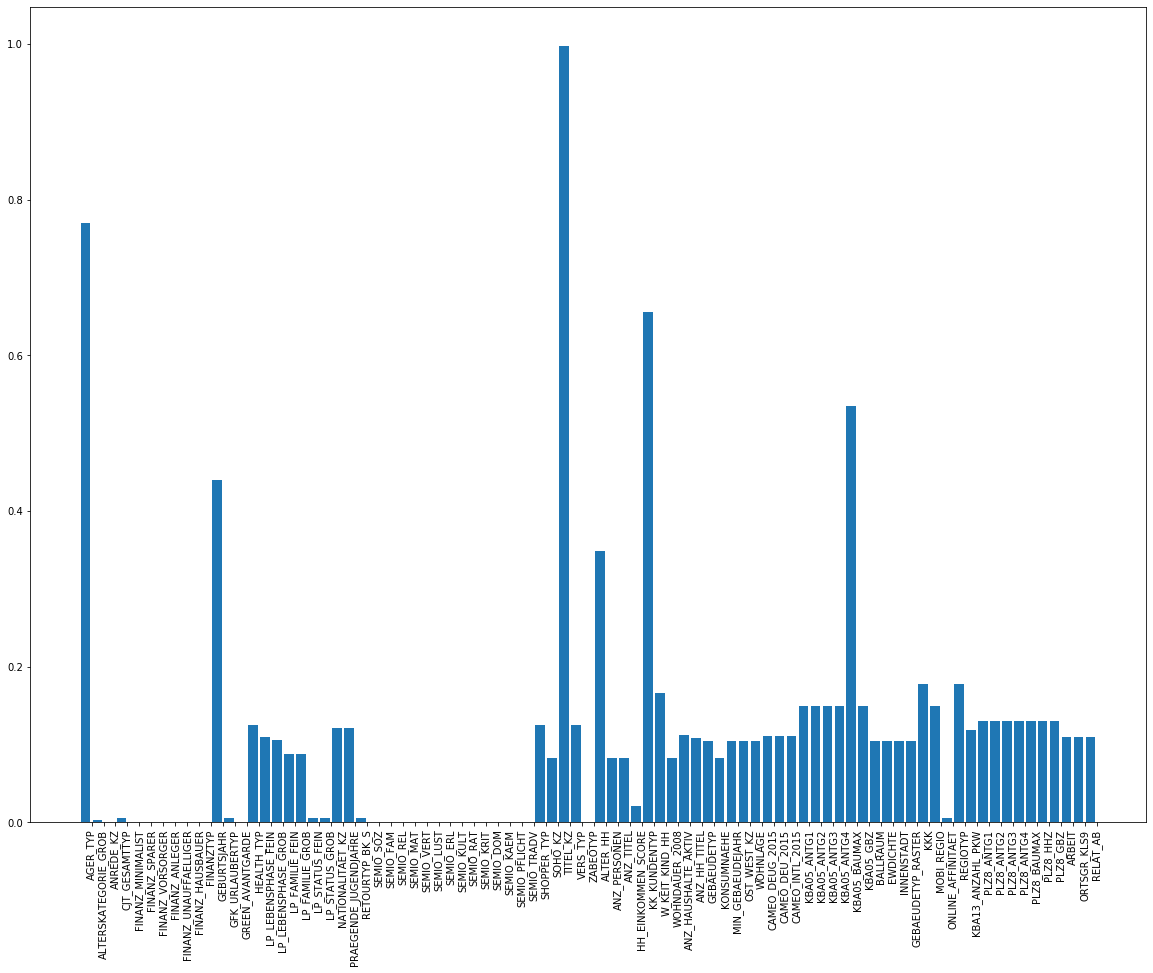

In [32]:
plt.figure(figsize=(20, 15))
plt.xticks(np.arange(len(null_counts)) + 0.5, null_counts.index, rotation='vertical')
plt.bar(np.arange(len(null_counts)), null_counts)

In [33]:
null_counts_hm = azdias_nans.isnull()

In [34]:
plt.figure(figsize=(30,20))

<Figure size 2160x1440 with 0 Axes>

<Figure size 2160x1440 with 0 Axes>

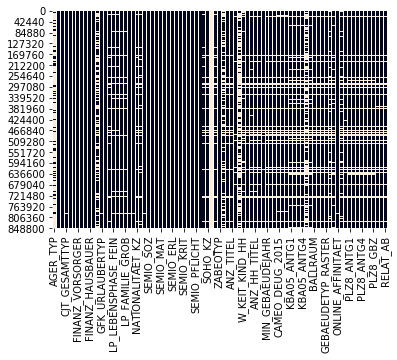

In [35]:
sns.heatmap(null_counts_hm, cbar=False)

In [36]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
null_counts.head(5) 
null_counts[null_counts > 0.40]


AGER_TYP        0.769554
GEBURTSJAHR     0.440203
TITEL_KZ        0.997576
KK_KUNDENTYP    0.655967
KBA05_BAUMAX    0.534687
dtype: float64

In [37]:
# Investigate patterns in the amount of missing data in each column.
azdias_nans['AGER_TYP'].head(20)



0     NaN
1     NaN
2     NaN
3     2.0
4     NaN
5     3.0
6     NaN
7     NaN
8     NaN
9     NaN
10    NaN
11    NaN
12    NaN
13    NaN
14    NaN
15    1.0
16    NaN
17    NaN
18    NaN
19    NaN
Name: AGER_TYP, dtype: float64

In [38]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
columns_to_drop = null_counts[null_counts > 0.4].index
azdias_dropped = azdias_nans.drop(columns_to_drop, axis=1)

In [39]:
azdias_dropped.shape

(891221, 80)

#### Discussion 1.1.2: Assess Missing Data in Each Column

- There were 5 columns removed that had over 40% of missing values. There are no patterns visible from the figures above. I can't see it why the data is missing, it seems to be just that that data is not there. Following columns were removed from the dataset: AGER_TYP, GEBURTSJAHR, TITEL_KZ, KK_KUNDENTYP, KBA05_BAUMAX.



#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [40]:
# How much data is missing in each row of the dataset?
row_null_counts = azdias_dropped.isnull().sum(axis=1)


In [41]:
row_null_counts

0         44
1          1
2          0
3          7
4          0
          ..
891216     3
891217     4
891218     5
891219     1
891220     1
Length: 891221, dtype: int64

In [42]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
no_missing_values = azdias_dropped[row_null_counts == 0]
no_missing_values.shape

(453093, 80)

In [43]:
with_missing_values = azdias_dropped[row_null_counts > 0]
with_missing_values.shape

(438128, 80)

In [44]:
with_missing_values['NATIONALITAET_KZ'].head(30)

0     NaN
1     1.0
3     1.0
6     1.0
11    NaN
12    1.0
13    1.0
14    NaN
15    1.0
16    3.0
17    NaN
18    2.0
19    1.0
20    1.0
21    1.0
22    1.0
23    2.0
24    NaN
25    1.0
26    1.0
29    1.0
30    1.0
31    1.0
34    NaN
35    NaN
36    1.0
38    2.0
39    1.0
40    1.0
42    1.0
Name: NATIONALITAET_KZ, dtype: float64

In [45]:
no_missing_values.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP',
       'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN',
       'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB',
       'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S',
       'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT',
       'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT',
       'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'ALTER_HH',
       'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH',
       'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP',
       'KONSUMNAEHE', 'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE',
       'CAMEO_DEUG_2

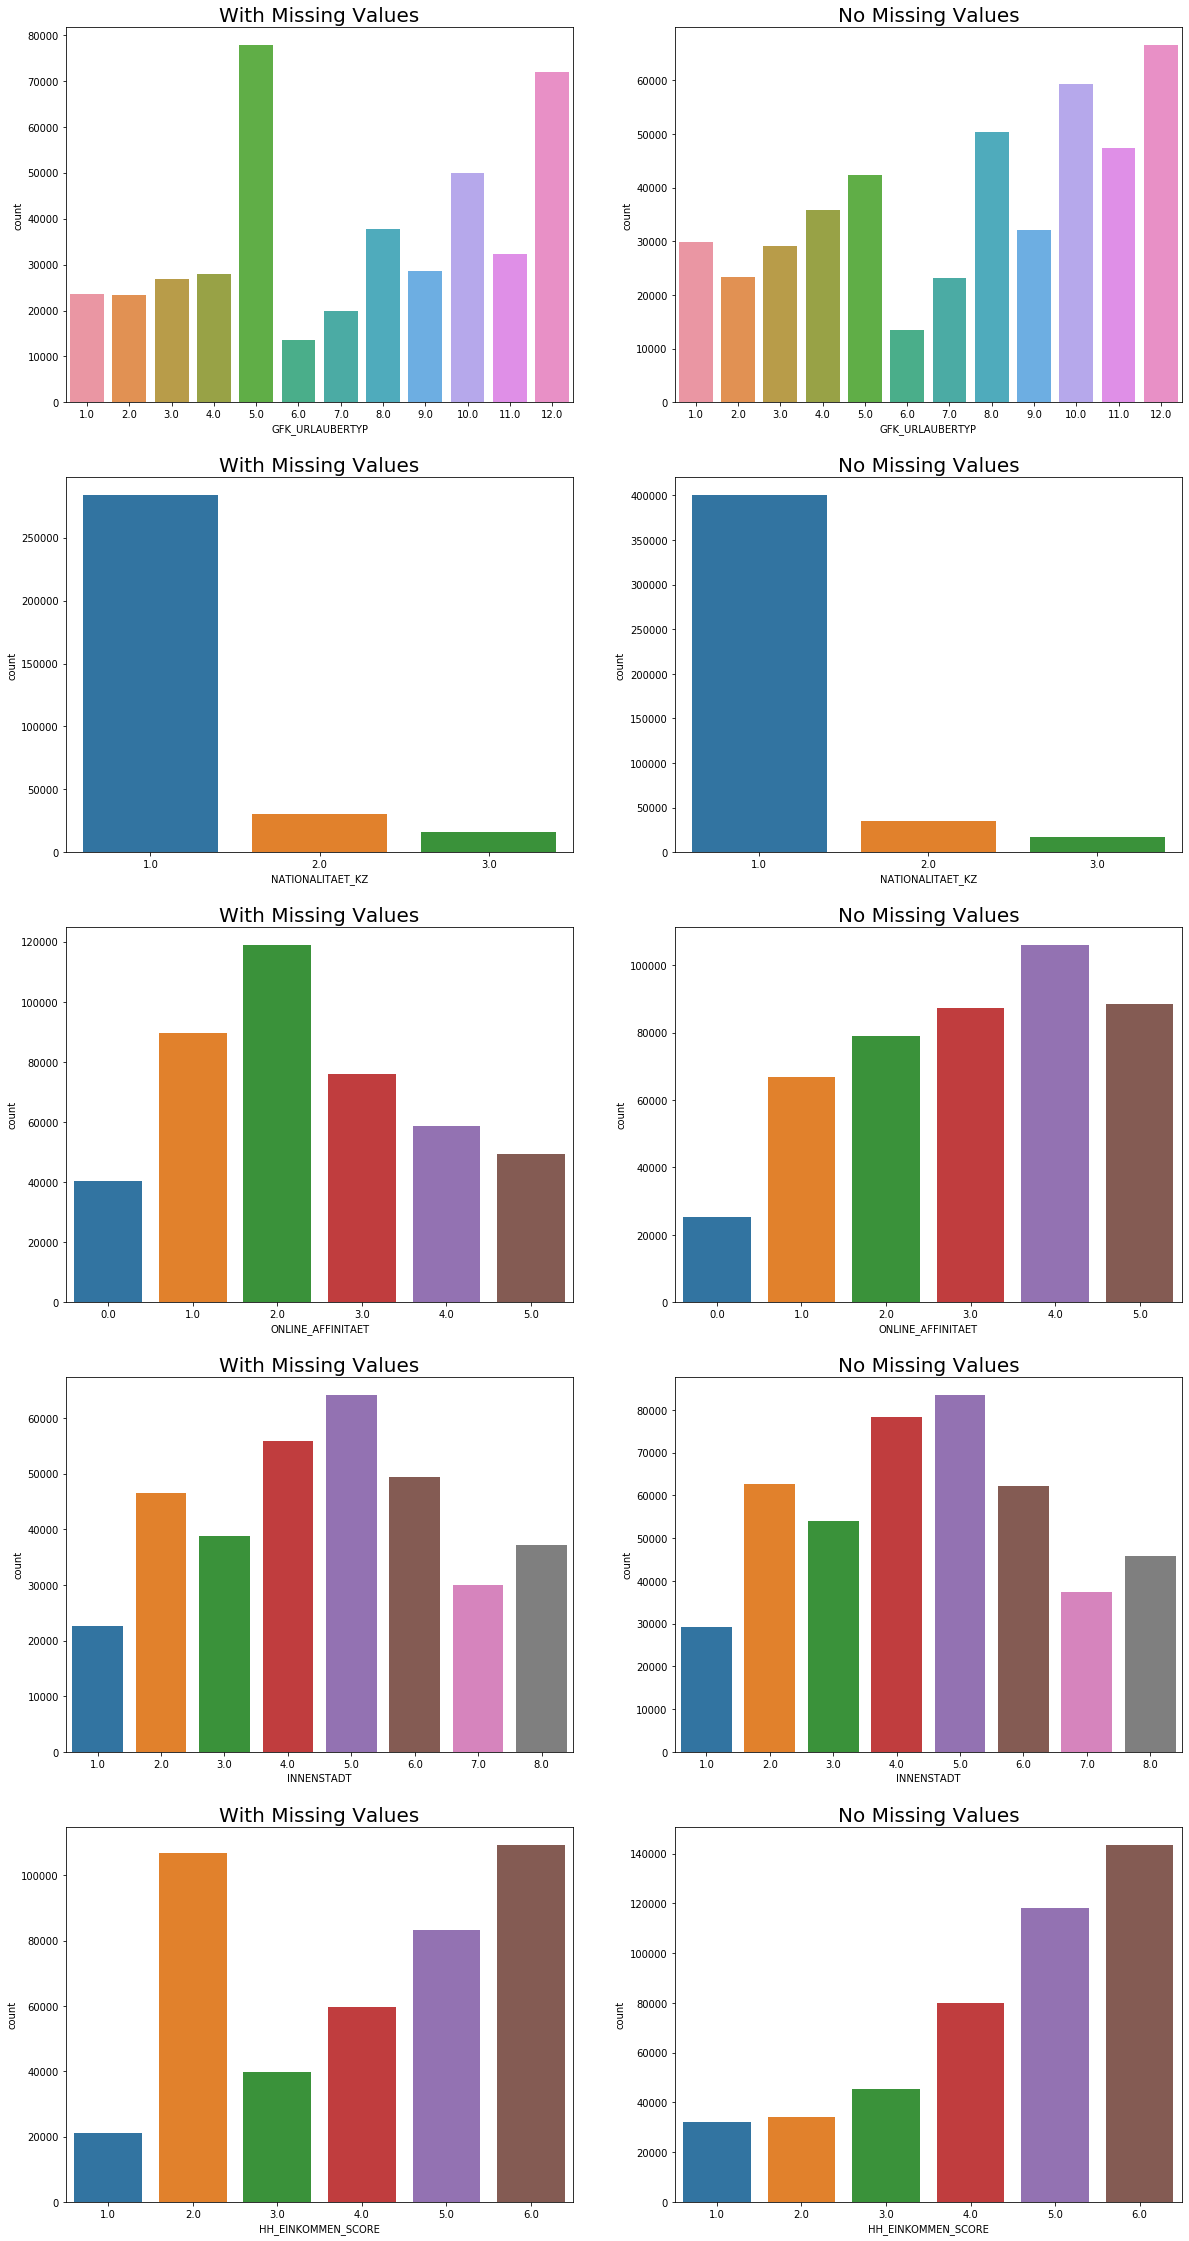

In [46]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

def plot_values(nrows, ncols, df1, df2, col_names):
    fig = plt.figure(figsize=(20,40))
    for ix, n in enumerate([x for x in range(nrows * ncols) if x % 2 != 0]):
        ax = fig.add_subplot(nrows, ncols, n)
        sns.countplot(data=df1, x=col_names[ix]).set_title('With Missing Values', fontsize=20)
        ax = fig.add_subplot(nrows, ncols, n + 1)
        sns.countplot(data=df2, x=col_names[ix]).set_title('No Missing Values', fontsize=20)
    plt.show()
    
plot_values(5, 2, with_missing_values, no_missing_values, ['GFK_URLAUBERTYP', 
                            'NATIONALITAET_KZ', 
                            'ONLINE_AFFINITAET', 
                            'INNENSTADT', 
                            'HH_EINKOMMEN_SCORE' 
                           ])


#### Discussion 1.1.3: Assess Missing Data in Each Row

Almost every column except INNENSTADT (inner city) and NATIONALITAET_KZ columns show a different distribution of data. While in the df with no missing columns the data follows some sort of distribution, in the df with missing values there is often one single column that does include most of the values. See ONLINE_AFFINITAET, HH_EINKOMMEN_SCORE or GFK_URLAUBERTYP. Probably it comes from the fact, that somehow the data was not collected properly, maybe it the data was filled by an educated guess or somewhat similar.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [47]:
# How many features are there of each data type?

categorical = feat_info.loc[:, 'type'] == 'categorical'
numeric = feat_info.loc[:, 'type'] == 'numeric'
mixed = feat_info.loc[:, 'type'] == 'mixed'
interval = feat_info.loc[:, 'type'] == 'interval'

print('Interval data: ', len(feat_info[interval]['attribute'].unique()))
print('Numeric data: ', len(feat_info[numeric]['attribute'].unique()))

print('Categorical data', len(feat_info[categorical]['attribute'].unique()))
print('Mixed data: ', len(feat_info[mixed]['attribute'].unique()))

feat_info.columns
feat_info.loc[:, 'type'].unique()



Interval data:  1
Numeric data:  7
Categorical data 21
Mixed data:  7


array(['categorical', 'ordinal', 'numeric', 'mixed', 'interval'],
      dtype=object)

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [48]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

# Getting categorical values for further analysis and encoding
categorical_cols = feat_info[categorical]['attribute'].unique()

# Columns already dropped due to missing data, needs to be excluded
dropped_cols = ['AGER_TYP', 'KK_KUNDENTYP', 'TITEL_KZ']
cat_cols_list = categorical_cols.tolist()
clean_categorical = [x for x in cat_cols_list if x not in dropped_cols]


In [49]:
# Investigation of categoricals which are binary which are multi level
number_of_categorical = no_missing_values[clean_categorical].apply(lambda x: x.nunique())
number_of_categorical

ANREDE_KZ            2
CJT_GESAMTTYP        6
FINANZTYP            6
GFK_URLAUBERTYP     12
GREEN_AVANTGARDE     2
LP_FAMILIE_FEIN     11
LP_FAMILIE_GROB      5
LP_STATUS_FEIN      10
LP_STATUS_GROB       5
NATIONALITAET_KZ     3
SHOPPER_TYP          4
SOHO_KZ              2
VERS_TYP             2
ZABEOTYP             6
GEBAEUDETYP          3
OST_WEST_KZ          2
CAMEO_DEUG_2015      9
CAMEO_DEU_2015      44
dtype: int64

In [50]:
# Getting binary and multi level catigoricals for encoding
binary = number_of_categorical[number_of_categorical == 2]
multi_level = number_of_categorical[number_of_categorical > 2]
print('Binary :\n', binary, '\n')
print('Multi-level:\n ', multi_level)

binary_xs = binary.index.tolist()
multi_level_xs = multi_level.index.tolist()

Binary :
 ANREDE_KZ           2
GREEN_AVANTGARDE    2
SOHO_KZ             2
VERS_TYP            2
OST_WEST_KZ         2
dtype: int64 

Multi-level:
  CJT_GESAMTTYP        6
FINANZTYP            6
GFK_URLAUBERTYP     12
LP_FAMILIE_FEIN     11
LP_FAMILIE_GROB      5
LP_STATUS_FEIN      10
LP_STATUS_GROB       5
NATIONALITAET_KZ     3
SHOPPER_TYP          4
ZABEOTYP             6
GEBAEUDETYP          3
CAMEO_DEUG_2015      9
CAMEO_DEU_2015      44
dtype: int64


In [51]:
# Encoding binary categoricals that takes a non-numeric values
no_missing_values_binary_encoded = pd.get_dummies(no_missing_values, columns=['OST_WEST_KZ'])

In [52]:
# Encoding multi level categoricals  
# Re-encode categorical variable(s) to be kept in the analysis.
no_missing_values_multi_encoded = pd.get_dummies(no_missing_values_binary_encoded,
                                                columns= multi_level_xs)

#### Discussion 1.2.1: Re-Encode Categorical Features

There are already some categorical columns dropped due to missing data. These are: ['AGER_TYP', 'KK_KUNDENTYP', 'TITEL_KZ']. After getting a list of columns with categoricals, I've counted which column has binary, or multi level categoricals. There are 4 binary categoricals and 14 multi level categoricals. The binary categorical 'OST_WEST_KZ' was encoded as numerical value.

I didn't dropped any multi level catigorcials. All multi level categoricals were encoded as dummy variables. The decision was made not to drop any data now. More data more insights. At least I was thining that I can drop the column later in the process. Right now there is not need to drop them at least I don't see why. 


(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [53]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
feat_info[mixed]['attribute']
no_missing_values_multi_encoded['PRAEGENDE_JUGENDJAHRE'].head(5)
decade = no_missing_values_multi_encoded['PRAEGENDE_JUGENDJAHRE'].map({
    1: 0,
    2: 0,
    3: 1,
    4: 1,
    5: 2,
    6: 2,
    7: 2,
    8: 3,
    9: 3,
    10: 4,
    11: 4,
    12: 4,
    13: 4,
    14: 5,
    15: 5
})

# 0 Mainstream
# 1 Avantgarde
movement = no_missing_values_multi_encoded['PRAEGENDE_JUGENDJAHRE'].map({
    1: 0,
    2: 1,
    3: 0,
    4: 1,
    5: 0,
    6: 1,
    7: 1,
    8: 0,
    9: 1,
    10: 0,
    11: 1,
    12: 0,
    13: 1,
    14: 0,
    15: 1
})

no_missing_values_multi_encoded['DECADE'] = decade
no_missing_values_multi_encoded['MOVEMENT'] = movement


In [54]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
def cameo(pos):
    def inner(val):
        return (int(str(val)[0]), int(str(val)[1]))[pos]
    return inner

    
wealth = no_missing_values_multi_encoded['CAMEO_INTL_2015'].apply(cameo(0))
life_stage = no_missing_values_multi_encoded['CAMEO_INTL_2015'].apply(cameo(1))



In [55]:
no_missing_values_multi_encoded['WEALTH'] = wealth
no_missing_values_multi_encoded['LIFE_STAGE'] = life_stage

In [56]:
feat_info[mixed]

attribute information_level   type missing_or_unknown
15    LP_LEBENSPHASE_FEIN            person  mixed                [0]
16    LP_LEBENSPHASE_GROB            person  mixed                [0]
22  PRAEGENDE_JUGENDJAHRE            person  mixed            [-1, 0]
56               WOHNLAGE          building  mixed               [-1]
59        CAMEO_INTL_2015     microcell_rr4  mixed           [-1, XX]
64           KBA05_BAUMAX     microcell_rr3  mixed            [-1, 0]
79            PLZ8_BAUMAX    macrocell_plz8  mixed            [-1, 0]

In [57]:
no_missing_values_multi_encoded = no_missing_values_multi_encoded.drop(
    ['LP_LEBENSPHASE_FEIN', 
     'LP_LEBENSPHASE_GROB', 
     'PLZ8_BAUMAX', 
     'PRAEGENDE_JUGENDJAHRE',
     'CAMEO_INTL_2015'
    ], axis=1)

#### Discussion 1.2.2: Engineer Mixed-Type Features

I dediced to drop LP_LEBENSPHASE_FEIN / LP_LEBENSPHASE_GROB since the information of these features is already included in wealth and life_stage. I decided to keep WOHNLAGE because it shows neighborhood quality which seems to be an important metric. I did no further feature engineering on WOHNLAGE, the current classification seems to be ok. Also I did kept KBA05_BAUMAX as it is. It shows the most common building type within the microcell. The classification seems to be okay, so there is no need to do some feature engineering. I made a decision to drop PLZ8_BAUMAX, since these information fits only the customers who are coming from the specific postal area.

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [58]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

# nothing to do here

In [59]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

# nothing to do here

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [60]:
import numpy as np
import pandas as pd
import json
from functools import reduce

pipe = lambda fns: lambda x: reduce(lambda v, f: f(v), fns, x)

def load_dfs(args):
    dir_main, dir_feat, nrows = args
    return (pd.read_csv(dir_main, delimiter=';', nrows=nrows),
            pd.read_csv(dir_feat, delimiter=';'))

def missing_to_list(dfs):
    main_df, feat_df = dfs
    feat_df_xs = feat_df['missing_or_unknown'].apply(lambda x: x[1:-1].split(','))
    feat_df_enc = feat_df_xs.apply(lambda x: list(map(lambda y: y if y == 'XX' or y == 'X' or y == '' else int(y), x)))
    feat_df['missing_or_unknown'] = feat_df_enc
    return (main_df, feat_df)

def attribute_as_index(dfs):
    main_df, feat_df = dfs
    return (main_df, feat_df.set_index('attribute'))

def nans_transformer(feat_df):
    def inner(row):
        missing_values = feat_df.loc[row.name, 'missing_or_unknown']
        checked = row.isin(missing_values)
        return row.where(~checked)
    return inner

def convert_missing_nans(dfs):
    main_df, feat_df = dfs
    return (main_df.apply(nans_transformer(feat_df)), feat_df)

def null_cols_drop(dfs):
    main_df, feat_df = dfs
    null_columns_count = main_df.isnull().sum() / len(main_df)
    above_40 = null_columns_count[null_columns_count > 0.4].index
    return (main_df.drop(above_40, axis=1), feat_df)

def null_rows_drop(dfs):
    main_df, feat_df = dfs
    null_rows_count = main_df.isnull().sum(axis=1)
    return (main_df[null_rows_count == 0], feat_df)

def re_encode_cats(dfs):
    main_df, feat_df = dfs
    categorical = feat_df.loc[:, 'type'] == 'categorical'
    categorical_cols = feat_df[categorical].index.tolist()
    dropped_cols = ['AGER_TYP', 'KK_KUNDENTYP', 'TITEL_KZ']
    clean_categorical = [x for x in categorical_cols if x not in dropped_cols]
    number_of_categorical = main_df[clean_categorical].apply(lambda x: x.nunique())
    multi_level_xs = number_of_categorical[number_of_categorical > 2].index.tolist()
    encode_binary = pd.get_dummies(main_df, columns=['OST_WEST_KZ'])
    encode_multi = pd.get_dummies(encode_binary, columns=multi_level_xs)
    return (encode_multi, feat_df)

def mixed_type_decade(dfs):
    main_df, feat_df = dfs
    main_df['DECADE'] = main_df['PRAEGENDE_JUGENDJAHRE'].map({
            1: 0,
            2: 0,
            3: 1,
            4: 1,
            5: 2,
            6: 2,
            7: 2,
            8: 3,
            9: 3,
            10: 4,
            11: 4,
            12: 4,
            13: 4,
            14: 5,
            15: 5
            })
    return (main_df, feat_df)

def mixed_type_movement(dfs):
    main_df, feat_df = dfs
    main_df['MOVEMENT'] = main_df['PRAEGENDE_JUGENDJAHRE'].map({
            1: 0,
            2: 1,
            3: 0,
            4: 1,
            5: 0,
            6: 1,
            7: 1,
            8: 0,
            9: 1,
            10: 0,
            11: 1,
            12: 0,
            13: 1,
            14: 0,
            15: 1
            })
    return (main_df, feat_df)

def cameo(pos):
    def inner(val):
        return (int(str(val)[0]), int(str(val)[1]))[pos]
    return inner
   
def mixed_type_cameo(dfs):
    main_df, feat_df = dfs
    main_df['WEALTH'] = main_df['CAMEO_INTL_2015'].apply(cameo(0))
    main_df['LIFE_STAGE'] = main_df['CAMEO_INTL_2015'].apply(cameo(1))
    return (main_df, feat_df)

def mixed_types_drop(dfs):
    main_df, _ = dfs
    return main_df.drop(['LP_LEBENSPHASE_FEIN', 
            'LP_LEBENSPHASE_GROB', 
            'PLZ8_BAUMAX', 
            'PRAEGENDE_JUGENDJAHRE',
            'CAMEO_INTL_2015'
            ], axis=1)

clean_data = pipe([
        load_dfs,
        missing_to_list,
        attribute_as_index,
        convert_missing_nans,
        null_cols_drop,
        null_rows_drop,
        re_encode_cats,
        mixed_type_decade,
        mixed_type_movement,
        mixed_type_cameo,
        mixed_types_drop,
        ])

df = clean_data(('../inputs/Udacity_AZDIAS_Subset.csv', '../inputs/AZDIAS_Feature_Summary.csv', None))

In [61]:
df.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP',
       ...
       'CAMEO_DEU_2015_8D', 'CAMEO_DEU_2015_9A', 'CAMEO_DEU_2015_9B',
       'CAMEO_DEU_2015_9C', 'CAMEO_DEU_2015_9D', 'CAMEO_DEU_2015_9E', 'DECADE',
       'MOVEMENT', 'WEALTH', 'LIFE_STAGE'],
      dtype='object', length=191)

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [62]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

# Data seems to be clean, no missing values are visible
s = df.isnull().sum()
s.values



array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [63]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(df)

### Discussion 2.1: Apply Feature Scaling

Since the finished df has no Nan's or other sort of missing values, there was nothing to do. The feature scaling was applied to all features in the dataframe.

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [64]:
# Visualize components
def scree_plot(pca):
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_

    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r'%s%%' % ((str(vals[i]*100)[:4])), 
                    (ind[i]+0.2, vals[i]), va='bottom', ha='center', fontsize=12)

    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
    
    ax.set_xlabel('Principal Component')
    ax.set_ylabel('Variance Explained (%)')
    plt.title('Explained Variance Per Principal Component')

In [65]:
# Apply PCA to the data.
from sklearn.decomposition import PCA


pca = PCA()
X_pca = pca.fit_transform(X)



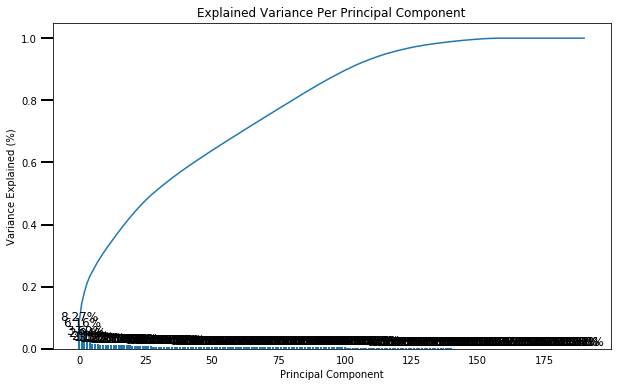

In [66]:
# Investigate the variance accounted for by each principal component.
scree_plot(pca)

In [67]:
def explain_var(pca):
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
    cumvals = np.cumsum(vals)
    return list(zip(ind, cumvals))

explain_var(pca)

[(0, 0.08273316543232122),
 (1, 0.14439084435947083),
 (2, 0.18133172389651553),
 (3, 0.21080683731430774),
 (4, 0.2323490133895748),
 (5, 0.24860156683010348),
 (6, 0.26437053248592723),
 (7, 0.2796020847022918),
 (8, 0.29337592411635693),
 (9, 0.3065863971974422),
 (10, 0.3191607150551651),
 (11, 0.3312272404194305),
 (12, 0.343023104244174),
 (13, 0.3546308682355575),
 (14, 0.3662064327377047),
 (15, 0.37767865302658354),
 (16, 0.38883195979766244),
 (17, 0.39975898620933265),
 (18, 0.4104174837318995),
 (19, 0.42105820397727106),
 (20, 0.4312808566987676),
 (21, 0.4411441508598599),
 (22, 0.45071953707826157),
 (23, 0.4600332066956528),
 (24, 0.4689739342279964),
 (25, 0.4775490881720321),
 (26, 0.4858892996082441),
 (27, 0.493957892940317),
 (28, 0.5013259820624847),
 (29, 0.5086071722534264),
 (30, 0.5157732584392078),
 (31, 0.522758319935977),
 (32, 0.5296163832806344),
 (33, 0.5363897062454343),
 (34, 0.5431146733089489),
 (35, 0.5496788213403404),
 (36, 0.5561672875173538),
 (

In [68]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components=116)
X_pca = pca.fit_transform(X)
np.sum(pca.explained_variance_ratio_)



0.9482787590143427

### Discussion 2.2: Perform Dimensionality Reduction

I made a decision to go with 116 principal components. They eplain almost 0.95 of the variability in the data. It seems to be a legit number.

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [69]:
np.set_printoptions(suppress=True)
pd.set_option('display.max_rows', None) 

In [73]:
weights = pca.components_

In [74]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def print_weights(comp_number, weights):
    return pd.DataFrame(weights, columns=df.columns).iloc[comp_number, :].sort_values()

print_weights(0, weights)


MOBI_REGIO              -0.203843
KBA05_ANTG1             -0.192183
FINANZ_MINIMALIST       -0.191767
KBA05_GBZ               -0.181209
PLZ8_ANTG1              -0.180851
PLZ8_GBZ                -0.134518
KONSUMNAEHE             -0.129711
INNENSTADT              -0.123912
LP_STATUS_FEIN_10.0     -0.122645
LP_STATUS_GROB_5.0      -0.122645
GREEN_AVANTGARDE        -0.113295
MOVEMENT                -0.113295
LIFE_STAGE              -0.110513
LP_STATUS_GROB_4.0      -0.101007
LP_STATUS_FEIN_9.0      -0.100732
ZABEOTYP_1              -0.098286
ALTERSKATEGORIE_GROB    -0.093246
BALLRAUM                -0.092962
FINANZ_VORSORGER        -0.092698
GEBAEUDETYP_RASTER      -0.092557
ANZ_PERSONEN            -0.087390
GEBAEUDETYP_1.0         -0.086397
CAMEO_DEUG_2015_2       -0.085123
FINANZTYP_2             -0.080279
CAMEO_DEUG_2015_4       -0.071872
SEMIO_LUST              -0.071284
LP_FAMILIE_GROB_5.0     -0.067583
WOHNDAUER_2008          -0.067189
CAMEO_DEUG_2015_3       -0.062804
KBA13_ANZAHL_P

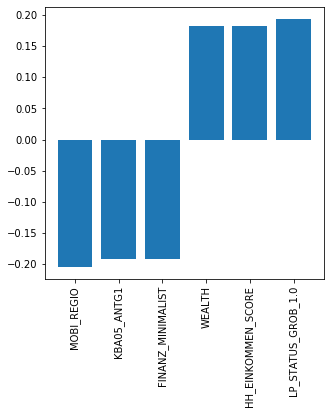

In [98]:
def plot_weights(comp_number, weights):
    weights_vals = pd.DataFrame(weights, columns=df.columns).iloc[comp_number, :].sort_values()
    x_head = weights_vals.index[:3].tolist()
    x_tail = weights_vals.index[-3:].tolist()
    y_head = weights_vals[:3]
    y_tail = weights_vals[-3:]
    fig = plt.figure(figsize=(5, 5))
    ax1 = fig.add_subplot(111)
    ax1.bar(np.arange(1,7), [*y_head, *y_tail])
    ax1.set_xticks(np.arange(1, 7))
    ax1.set_xticklabels([*x_head, *x_tail], rotation=90)
    plt.show()
    return 

plot_weights(0, weights)


In [ ]:
#df.plot.scatter(x='HH_EINKOMMEN_SCORE', y='KBA05_ANTG1')


In [ ]:
df['HH_EINKOMMEN_SCORE'].corr(df['WEALTH'])

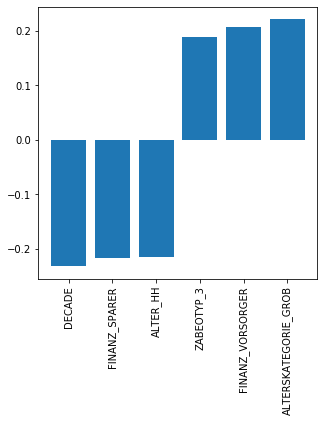

In [100]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
print_weights(1, weights)
plot_weights(1, weights)



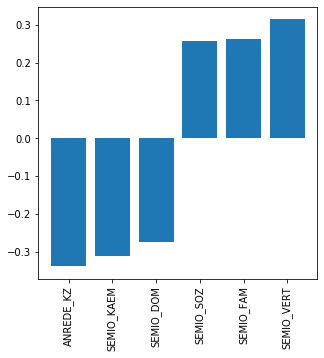

In [99]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

print_weights(2, weights)
plot_weights(2, weights)



### Discussion 2.3: Interpret Principal Components

For the first principal component, we can see that WEALTH does correlate to HH_EINKOMMEN_SCORE (income score) and LP_STATUS_GROB (social status). Which is reasonable, since all those things are strongly correlated together. In contrast, those features are negatively correlated to MOBIO_REGIO which describes the movement pattern. Also, income is correlated negatively correlated to KBA05_ANTG1 which does describe the number of 1-2 family houses in the microcell. Just by running correlation check we can see a negative correlation`df['HH_EINKOMMEN_SCORE'].corr(df['KBA05_ANTG1'])` gives us -0.612 correlation.

While analyzing the second component we can see that FINANZ_VORSORGER (financial typology) highly correlates to ALTERSKATEGORIE_GROB (estimated age). It does have a positive correlation. What is interesting here is that FINANZ_VORSORGER has a negative correlation to FINANZ_SPARER (money-saver) and FINANZ_ANLEGER (investor). Which could make sense since someone who saves money doesn't usually invest it? The difference between those both is not really clear. `df['FINANZ_VORSORGER'].corr(df['FINANZ_SPARER'])` gives us -0.839 correlation

The third component shows us that SEMIO_VERT, FAM, SOZ, KULT are highly correlated together. and SEMIO_KAEM (combative attribute), DOM (dominant-minded), KRIT (critical) are highly correlated together too. When we compare them against each other, we see that they show a negative correlation e.g. SEMIO_FAM (family-minded), SEMIO_SOZ(socially-minded) vs. SEMIO_KAEM (combative attitude), SEMIO_DOM (dominant-minded)

In a nutshell, we can say that based on the weights of PC's we can see which features do correlate positively/negatively.


(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [195]:
# Over a number of different cluster counts...


    # run k-means clustering on the data and...
    
    
    # compute the average within-cluster distances.
    
from math import sqrt
from sklearn.cluster import KMeans
    
def scoring(k, data):
    k = KMeans(k)
    m = k.fit(data)
    return sqrt(int(m.score(data) ** 2))

ks = range(1, 25)

def run_scoring(ks, X_pca):
    return [scoring(k, X_pca) for k in ks]

y = run_scoring(ks, X_pca)

Text(0.5, 1.0, 'SSE vs. K')

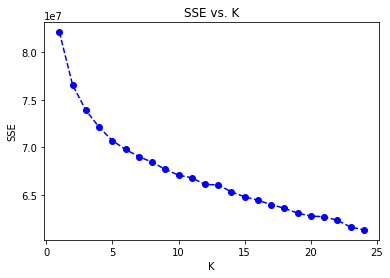

In [196]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.plot(ks, y, linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('SSE')
plt.title('SSE vs. K')

In [ ]:
for i, v in enumerate(y):
    print((i + 1, v))

In [109]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
k = 19
kmeans = KMeans(k, random_state=1).fit(X_pca)
clusters_population = kmeans.predict(X_pca)


### Discussion 3.1: Apply Clustering to General Population

While with more clusters the error score gets lower. I made a decision to go with 19 clusters. It seems that from that timepoint the score gets lowered not so quickly. But due to time constraints I was not able to run with more than 25 clusters.

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [ ]:
# Load in the customer demographics data.
# see next cell the df was loaded and preprocessed
customers = None # see next cell 

In [110]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_df = df = clean_data(('../inputs/Udacity_CUSTOMERS_Subset.csv', '../inputs/AZDIAS_Feature_Summary.csv', None))

In [111]:
customers_df_scaled = scaler.transform(customers_df)
customers_df_pca = pca.transform(customers_df_scaled)

In [112]:
clusters_customers = kmeans.predict(customers_df_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [128]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

def normalize_plot(cluster):
    percentage = lambda i: len(i)/float(len(cluster)) * 100
    sns.barplot(x=cluster, y=cluster, estimator=percentage)


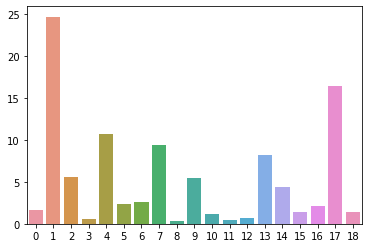

In [129]:
# Distribution among the clusters for customers
normalize_plot(clusters_customers)

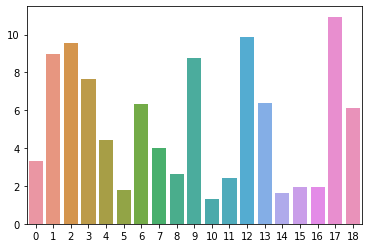

In [130]:
# Distribution among the clusters for the general population
normalize_plot(clusters_population)

In [192]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# cluster #1 is overrepresented in the cutomer data

def show_segments(cluster_number, df, model):
    centers = model.cluster_centers_
    pca_inverse = pca.inverse_transform(centers)
    scale_inverse = scaler.inverse_transform(pca_inverse)
    cluster_center_df = pd.DataFrame(scale_inverse, columns=customers_df.columns).round(0)
    return cluster_center_df.loc[cluster_number, :]

show_segments(1, customers_df, kmeans)

ALTERSKATEGORIE_GROB        3.0
ANREDE_KZ                   1.0
FINANZ_MINIMALIST           5.0
FINANZ_SPARER               2.0
FINANZ_VORSORGER            4.0
FINANZ_ANLEGER              2.0
FINANZ_UNAUFFAELLIGER       2.0
FINANZ_HAUSBAUER            2.0
GREEN_AVANTGARDE            1.0
HEALTH_TYP                  2.0
RETOURTYP_BK_S              4.0
SEMIO_SOZ                   4.0
SEMIO_FAM                   3.0
SEMIO_REL                   3.0
SEMIO_MAT                   3.0
SEMIO_VERT                  5.0
SEMIO_LUST                  5.0
SEMIO_ERL                   5.0
SEMIO_KULT                  4.0
SEMIO_RAT                   3.0
SEMIO_KRIT                  4.0
SEMIO_DOM                   5.0
SEMIO_KAEM                  4.0
SEMIO_PFLICHT               3.0
SEMIO_TRADV                 3.0
SOHO_KZ                     0.0
VERS_TYP                    2.0
ALTER_HH                   15.0
ANZ_PERSONEN                2.0
ANZ_TITEL                  -0.0
HH_EINKOMMEN_SCORE          3.0
W_KEIT_K

In [194]:
# What kinds of people are part of a cluster that is underrepresented in the 
# customer data compared to the general population?

# The segment #12 is underrepresented in the customer data
show_segments(12, customers_df, kmeans)

ALTERSKATEGORIE_GROB        2.0
ANREDE_KZ                   2.0
FINANZ_MINIMALIST           1.0
FINANZ_SPARER               4.0
FINANZ_VORSORGER            2.0
FINANZ_ANLEGER              4.0
FINANZ_UNAUFFAELLIGER       4.0
FINANZ_HAUSBAUER            4.0
GREEN_AVANTGARDE            0.0
HEALTH_TYP                  2.0
RETOURTYP_BK_S              2.0
SEMIO_SOZ                   3.0
SEMIO_FAM                   4.0
SEMIO_REL                   5.0
SEMIO_MAT                   5.0
SEMIO_VERT                  2.0
SEMIO_LUST                  3.0
SEMIO_ERL                   4.0
SEMIO_KULT                  4.0
SEMIO_RAT                   6.0
SEMIO_KRIT                  5.0
SEMIO_DOM                   6.0
SEMIO_KAEM                  6.0
SEMIO_PFLICHT               6.0
SEMIO_TRADV                 6.0
SOHO_KZ                     0.0
VERS_TYP                    1.0
ALTER_HH                   18.0
ANZ_PERSONEN                2.0
ANZ_TITEL                   0.0
HH_EINKOMMEN_SCORE          6.0
W_KEIT_K

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)



The first cluster is overrepresented in the customer data. 
The cluster includes following features:

* ALTERSKATEGORIE_GROB (estimated age) -> 46 - 60 years old
* ANREDE_KZ (gender) -> male
* ALTER_HH (birthdate of head of household) -> 1965 - 1969
* HH_EINKOMMEN_SCORE (income score) -> high income
* WOHNLAGE (neighborhood quality) -> average neighborhood
* MOBIO_REGIO (movement pattern) -> low movement pattern

From the 1st customer we can conclude that they tend to older customers 46 - 60 years old, males, with high income and low movement patterns.

The 12th cluster is underrepresented in the customer data.
The cluster includes following features:

* ALTERSKATEGORIE_GROB (estimated age) -> 30 - 45 years old
* ANREDE_KZ (gender) -> female
* ALTER_HH (birthdate of head of household) -> 1980 - 1984
* HH_EINKOMMEN_SCORE (estimated household net income) -> ver low income
* WOHNLAGE (neighborhood quality) -> average neighborhood
* MOBEI_REGIO (movement patterns) -> high movement pattern

From the 12th cluster we can conclude that they avoid customer in the age of 30 - 45, females with a very low income and high movement patterns.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.